In [14]:
import torch as nn
### trying another way 
hidden = nn.load("/sc/arion/projects/shenl03_ml/2023_adriana_bc_risk/Mirai_test/Mirai/results/saved_hidden_20230825.pt")


#hidden
print(len(hidden[0]))
hidden[0]
type(hidden)

190


tuple

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.manifold import TSNE

# Extract hidden dimensions and paths
hidden_dimensions = hidden[0] #the 0 are the hidden representations and the 1 are the paths 
print(hidden_dimensions.shape)

(190, 4, 512)


In [88]:
#Flatten the data 
reshaped_representation = hidden_dimensions.reshape(-1, 512)
len(reshaped_representation) #760 (190*4)


760

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


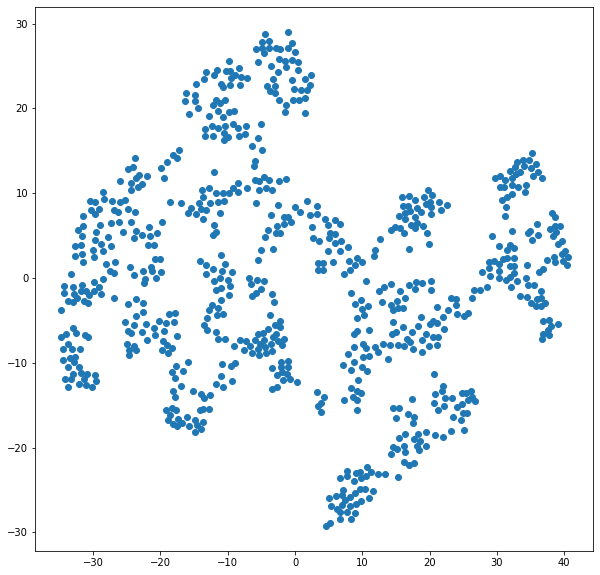

In [89]:
from sklearn.manifold import TSNE

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
reduced_dimensions = tsne.fit_transform(reshaped_representation)  # or use reshaped_dimensions

# Now, you can proceed with plotting as previously described.
# Plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1])


Adding information on the device type from the metadata, pulled form file_path

In [23]:
#Load the metadata 
import pandas as pd

metadata = pd.read_csv("/sc/arion/projects/shenl03_ml/2023_adriana_bc_risk/Mirai_test/Mirai/data/mssm_mammogram_metadata_for_mirai_w_device.csv")
metadata.head()

,patient_id,exam_id,laterality,view,file_path,years_to_cancer,years_to_last_followup,split_group,device_name
0,886954,1,L,CC,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,train,GE
1,886954,1,L,MLO,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,train,GE
2,886954,1,L,MLO,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,train,GE
3,886954,1,R,CC,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,train,GE
4,886954,1,R,MLO,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,train,GE


In [24]:
test_metadata = metadata[metadata['split_group'] == 'test']

grouped = test_metadata.groupby("patient_id").apply(lambda x: set(zip(x["view"], x["laterality"]))).reset_index()
grouped.columns = ["patient_id", "combinations"]

desired_combinations = {('CC', 'L'), ('CC', 'R'), ('MLO', 'L'), ('MLO', 'R')}
complete_patients = grouped[grouped["combinations"] == desired_combinations]

count = len(complete_patients)
print(count) #172 patients


172


In [25]:
#extract device types 
device_types = []

for paths in hidden[1]:
    for path in paths.split("\t"):
        device = metadata[metadata['file_path'] == path]['device_name'].iloc[0]
        device_types.append(device)


Mapping the device type to the color 

In [26]:
#map device types to colors 
unique_devices = list(set(device_types))
colors = plt.cm.jet(np.linspace(0, 1, len(unique_devices))) #generate colors 

device_to_color = dict(zip(unique_devices, colors))
plot_colors = [device_to_color[device] for device in device_types]

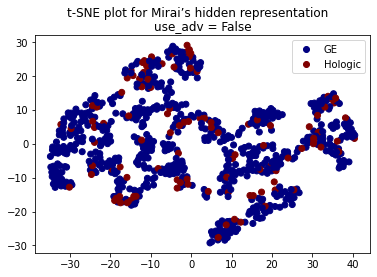

In [27]:
#plot tsne with colors and legend 
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], c=plot_colors)
for device, color in device_to_color.items():
    plt.plot([], [], 'o', color=color, label=device)
plt.legend(loc='best')
plt.suptitle("t-SNE plot for Mirai’s hidden representation")
plt.title("use_adv = False")
plt.show()


Examining how many patients have 4 images and how many do not, and looking at the difference between the dataframes. There are 190 patients in the hidden_representation and there are 172 patients who have all 4 views, this leaves 18 patients who do not have the 4 views. 

In [18]:
#patients that are in the tuple object 
all_paths = [path for sublist in hidden[1] for path in sublist.split("\t")]

subset_metadata = metadata[metadata['file_path'].isin(all_paths)]

# Get unique patient IDs
unique_patient_ids = subset_metadata['patient_id'].unique()

#final subset
final_subset = metadata[metadata['patient_id'].isin(unique_patient_ids)]
len(final_subset)


925

In [19]:
final_patient_ids = final_subset['patient_id'].unique()
complete_patient_ids = complete_patients['patient_id'].unique()

import numpy as np

different_patient_ids = np.setdiff1d(final_patient_ids, complete_patient_ids)

different_patients = final_subset[final_subset['patient_id'].isin(different_patient_ids)]

len(different_patients["patient_id"].unique()) #18 patients who do not have r and l cc and mlo
different_patients

,patient_id,exam_id,laterality,view,file_path,years_to_cancer,years_to_last_followup,split_group,device_name
98,195698,1,L,CC,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,test,GE
99,195698,1,L,MLO,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,test,GE
100,195698,1,L,MLO,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,test,GE
101,195698,1,L,XCCL,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,test,GE
102,195698,1,R,CC,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,test,GE
...,...,...,...,...,...,...,...,...,...
5638,693869,1,L,MLO,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,test,Hologic
5639,693869,1,L,XCCL,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,test,Hologic
5640,693869,1,R,CC,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,test,Hologic
5641,693869,1,R,MLO,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,test,Hologic


Some patients have XCCL as a view, look into what this could mean. 

Creating more tSNE plots

In [7]:
import pandas as pd
meta_info = pd.read_csv("/sc/arion/projects/shenl03_ml/2023_adriana_bc_risk/Mirai_test/mssm_mammography/mssm_mammography/meta_info/exams_metadata_2018-08-20.txt", sep='\t')
meta_info.head()

meta_info_exam1 = meta_info[meta_info['examIndex'] == 1]
meta_info_exam1.head()

,subjectId,examIndex,daysSincePreviousExam,cancerL,cancerR,invL,invR,age,implantEver,implantNow,...,cr_dxday_2,cr_dx_3,cr_laterality_3,cr_dxyear_3,cr_dxmonth_3,cr_dxday_3,manufacturer_dcm,MAMMOGRAM_ACCESSION_NUMBER,assessL_DREAM_r2,assessR_DREAM_r2
0,886954,1,0,0,0,0,0,55,0,.,...,.,.,.,.,.,.,GE,6318473,1/2,1/2
3,62061,1,0,0,0,0,0,41,0,.,...,.,.,.,.,.,.,GE,7390139,1/2,0
4,286748,1,0,0,0,0,0,55,0,.,...,.,.,.,.,.,.,GE,4203170,1,1
10,868567,1,0,0,0,0,0,62,0,.,...,.,.,.,.,.,.,GE,4273373,1,1
13,654734,1,0,0,0,0,0,50,0,.,...,.,.,.,.,.,.,GE,5083864,1/2,0


In [29]:
meta_info_exam1 = meta_info_exam1.rename(columns={'subjectId': 'patient_id'})
merged_df = metadata.merge(meta_info_exam1[['patient_id', 'age']], on='patient_id', how='left')
merged_df.head()



,patient_id,exam_id,laterality,view,file_path,years_to_cancer,years_to_last_followup,split_group,device_name,age
0,886954,1,L,CC,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,train,GE,55
1,886954,1,L,MLO,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,train,GE,55
2,886954,1,L,MLO,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,train,GE,55
3,886954,1,R,CC,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,train,GE,55
4,886954,1,R,MLO,/sc/arion/projects/Nestlerlab/shenl03_ml/2023_...,100,5,train,GE,55


Extract ages

In [36]:
ages = []

for paths in hidden[1]:
    for path in paths.split("\t"):
        age = merged_df[merged_df['file_path'] == path]['age'].iloc[0]
        ages.append(age)

len(ages) #760 


AttributeError: 'list' object has no attribute 'dtype'

In [39]:
unique_types = {type(age) for age in ages}
print(unique_types)

# Convert the string ages to floats
ages = [float(age) if isinstance(age, np.str_) else age for age in ages]
ages = np.array(ages)

{<class 'numpy.str_'>}


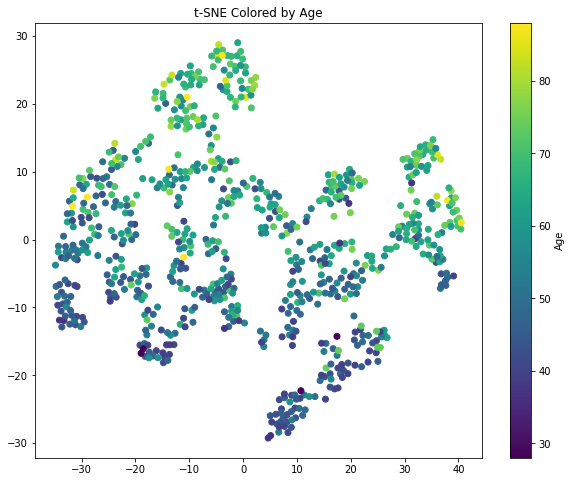

In [42]:
import numpy as np
#plotting 
plt.figure(figsize=(10, 8))
sc = plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], c=ages, cmap='viridis')
plt.colorbar(sc, label='Age')
plt.title('t-SNE Colored by Age')
plt.show()


Extract BMI

In [60]:
meta_info_exam1 = meta_info_exam1.rename(columns={'subjectId': 'patient_id'})
merged_df = metadata.merge(meta_info_exam1[['patient_id', 'bmi']], on='patient_id', how='left')
merged_df.head()

bmis = []

for paths in hidden[1]:
    for path in paths.split("\t"):
        bmi = merged_df[merged_df['file_path'] == path]['bmi'].iloc[0]
        bmis.append(bmi)

len(bmis) #760 

def safe_float_conversion(value):
    try:
        return float(value)
    except ValueError:
        return None  # or some default value, or np.nan

bmis = [safe_float_conversion(bmi) for bmi in bmis]


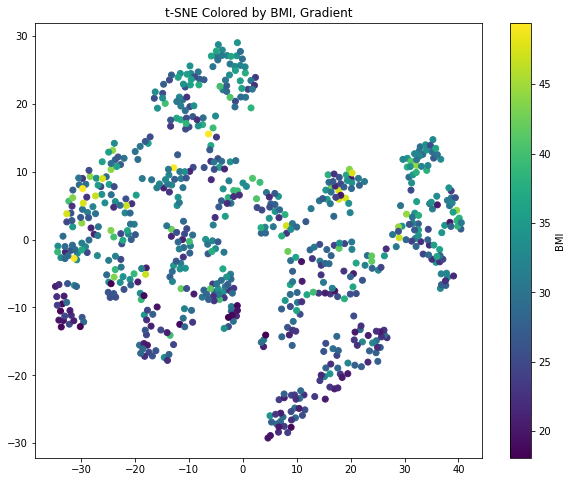

In [62]:
plt.figure(figsize=(10, 8))
sc = plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], c=bmis, cmap='viridis')
plt.colorbar(sc, label='BMI')
plt.title('t-SNE Colored by BMI, Gradient')
plt.show()

Recreating with categorized bmi 

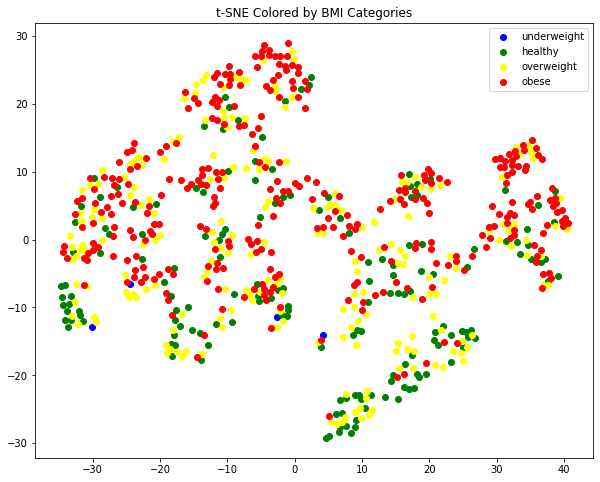

In [64]:
#need to remove the invalid bmi values 
valid_indices = [i for i, bmi in enumerate(bmis) if bmi is not None]
valid_bmis = [bmis[i] for i in valid_indices]
reduced_dimensions = reduced_dimensions[valid_indices]


def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'healthy'
    elif 25 <= bmi < 30:
        return 'overweight'
    else:
        return 'obese'

categories = [categorize_bmi(bmi) for bmi in valid_bmis]


#map categories 
color_map = {
    'underweight': 'blue', 
    'healthy': 'green',
    'overweight': 'yellow',
    'obese': 'red'
}

plot_colors = [color_map[cat] for cat in categories]

#plot tsne with categories 
plt.figure(figsize=(10, 8))
for category, color in color_map.items():
    indices = [i for i, c in enumerate(categories) if c == category]
    plt.scatter(reduced_dimensions[indices, 0], reduced_dimensions[indices, 1], color=color, label=category)
plt.legend()
plt.title('t-SNE Colored by BMI Categories')
plt.show()


Repeat but do it per individual 

/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/hpc/packages/minerva-centos7/py_packages/3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


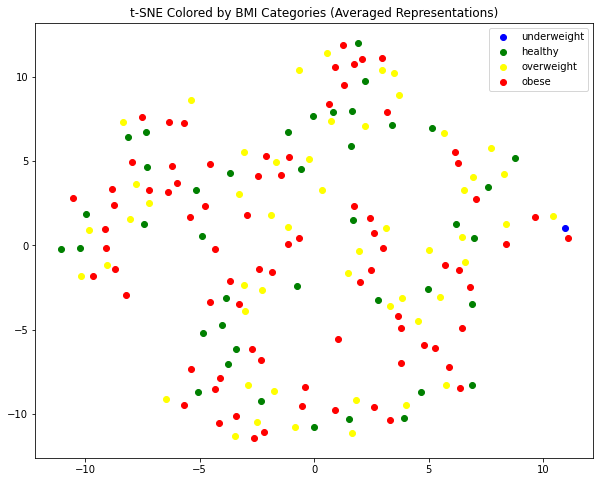

In [65]:
averaged_dimensions = np.mean(hidden_dimensions, axis=1)

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)  #adjust the parameters as needed
reduced_averaged_dimensions = tsne.fit_transform(averaged_dimensions)

# Extract one BMI value for each individual from the bmis list (which had 4 times the values)
valid_bmis_averaged = valid_bmis[::4]


#categorize 
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'healthy'
    elif 25 <= bmi < 30:
        return 'overweight'
    else:
        return 'obese'

categories = [categorize_bmi(bmi) for bmi in valid_bmis_averaged]


#map categories to colors and plot
plt.figure(figsize=(10, 8))
for category, color in color_map.items():
    indices = [i for i, c in enumerate(categories) if c == category]
    plt.scatter(reduced_averaged_dimensions[indices, 0], reduced_averaged_dimensions[indices, 1], color=color, label=category)
plt.legend()
plt.title('t-SNE Colored by BMI Categories (Averaged Representations)')
plt.show()



Race 

In [75]:
meta_info_exam1 = meta_info_exam1.rename(columns={'subjectId': 'patient_id'})
merged_df = metadata.merge(meta_info_exam1[['patient_id', 'race']], on='patient_id', how='left')
merged_df.head()

races = []

for paths in hidden[1]:
    path = paths.split("\t")[0]
    race = str(merged_df[merged_df['file_path'] == path]['race'].iloc[0])  # Convert race value to string
    races.append(race)


len(races) #190

190

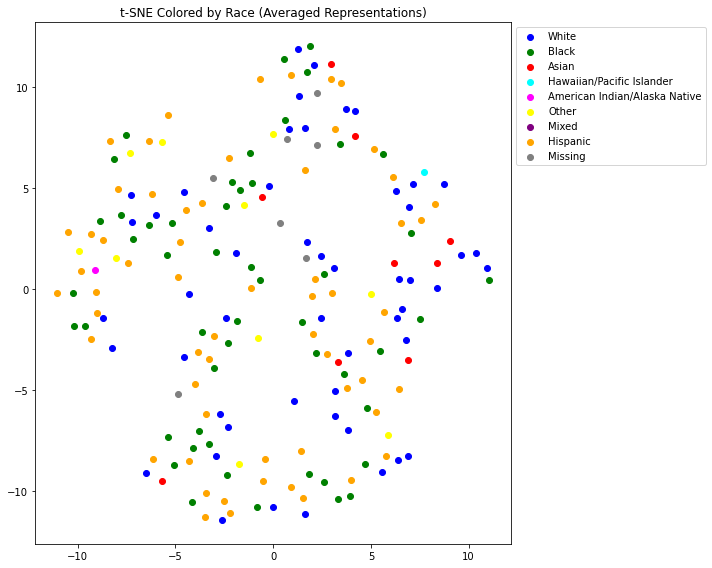

In [71]:
race_to_color = {
    '1': 'blue',   # White
    '2': 'green',  # Black
    '3': 'red',    # Asian
    '4': 'cyan',   # Hawaiian/Pacific Islander
    '5': 'magenta',# American Indian/Alaska Native
    '6': 'yellow', # Other
    '7': 'purple', # Mixed
    '8': 'orange', # Hispanic
    '9': 'gray'    # Missing
}

plot_colors = [race_to_color[race] for race in races]


plt.figure(figsize=(10, 8))
for race, color in race_to_color.items():
    # Map race names for legend
    race_name_mapping = {
        '1': 'White',
        '2': 'Black',
        '3': 'Asian',
        '4': 'Hawaiian/Pacific Islander',
        '5': 'American Indian/Alaska Native',
        '6': 'Other',
        '7': 'Mixed',
        '8': 'Hispanic',
        '9': 'Missing'
    }
    indices = [i for i, r in enumerate(races) if r == race]
    plt.scatter(reduced_averaged_dimensions[indices, 0], reduced_averaged_dimensions[indices, 1], color=color, label=race_name_mapping[race])

plt.title('t-SNE Colored by Race (Averaged Representations)')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Adjusts the location of the legend
plt.tight_layout()  # Adjusts the layout to fit the legend
plt.show()


density_birads (averaged) 

In [77]:
meta_info_exam1 = meta_info_exam1.rename(columns={'subjectId': 'patient_id'})
merged_df = metadata.merge(meta_info_exam1[['patient_id', 'density_birads']], on='patient_id', how='left')
merged_df.head()

density_birads = []

for paths in hidden[1]:
    path = paths.split("\t")[0]
    density_birad = str(merged_df[merged_df['file_path'] == path]['density_birads'].iloc[0])  # Convert race value to string
    density_birads.append(density_birad)


len(density_birads) #190


190

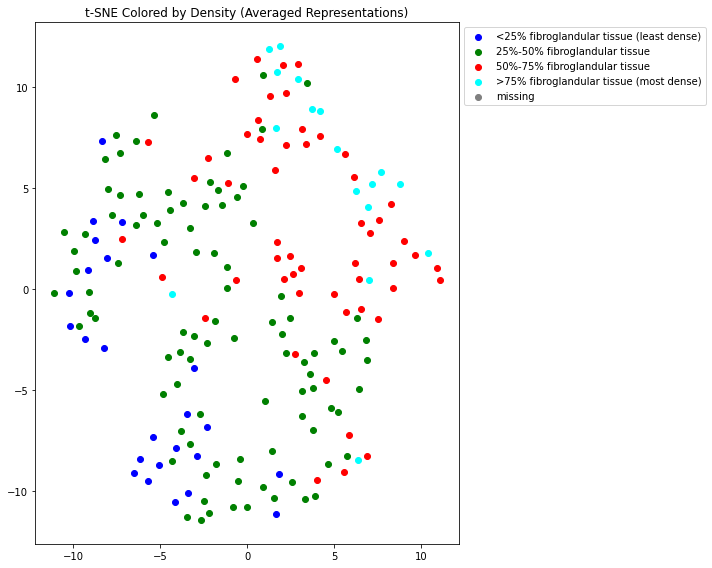

In [81]:
density_to_color = {
    'a': 'blue',     # <25% fibroglandular tissue (least dense)
    'b': 'green',    # 25%-50% fibroglandular tissue
    'c': 'red',      # 50%-75% fibroglandular tissue
    'd': 'cyan',     # >75% fibroglandular tissue (most dense)
    '.': 'gray'      # missing
}


plot_colors = [density_to_color[density] for density in density_birads]


plt.figure(figsize=(10, 8))
for density, color in density_to_color.items():
    # Map race names for legend
    density_name_mapping = {
        'a': '<25% fibroglandular tissue (least dense)',     
        'b': '25%-50% fibroglandular tissue',    
        'c': '50%-75% fibroglandular tissue',      
        'd': '>75% fibroglandular tissue (most dense)',     
        '.': 'missing'
    }
    indices = [i for i, r in enumerate(density_birads) if r == density]
    plt.scatter(reduced_averaged_dimensions[indices, 0], reduced_averaged_dimensions[indices, 1], color=color, label=density_name_mapping[density])

plt.title('t-SNE Colored by Density (Averaged Representations)')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Adjusts the location of the legend
plt.tight_layout()  # Adjusts the layout to fit the legend
plt.show()

density_birads (image level ) 

In [86]:
meta_info_exam1 = meta_info_exam1.rename(columns={'subjectId': 'patient_id'})
merged_df = metadata.merge(meta_info_exam1[['patient_id', 'density_birads']], on='patient_id', how='left')
merged_df.head()

density_birads = []

for paths in hidden[1]:
    for path in paths.split("\t"):
        density_birad = merged_df[merged_df['file_path'] == path]['density_birads'].iloc[0]
        density_birads.append(density_birad)


len(density_birads) #760


692


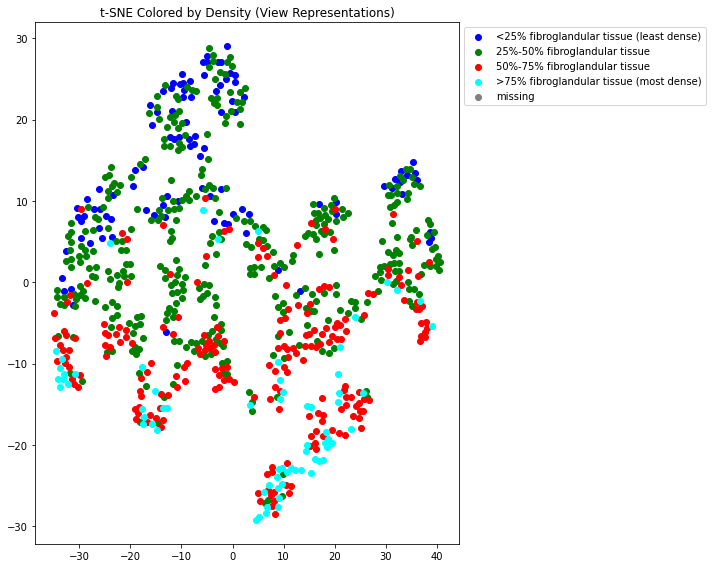

In [90]:
density_to_color = {
    'a': 'blue',     # <25% fibroglandular tissue (least dense)
    'b': 'green',    # 25%-50% fibroglandular tissue
    'c': 'red',      # 50%-75% fibroglandular tissue
    'd': 'cyan',     # >75% fibroglandular tissue (most dense)
    '.': 'gray'      # missing
}


plot_colors = [density_to_color[density] for density in density_birads]


plt.figure(figsize=(10, 8))
for density, color in density_to_color.items():
    # Map race names for legend
    density_name_mapping = {
        'a': '<25% fibroglandular tissue (least dense)',     
        'b': '25%-50% fibroglandular tissue',    
        'c': '50%-75% fibroglandular tissue',      
        'd': '>75% fibroglandular tissue (most dense)',     
        '.': 'missing'
    }
    indices = [i for i, r in enumerate(density_birads) if r == density]
    plt.scatter(reduced_dimensions[indices, 0], reduced_dimensions[indices, 1], color=color, label=density_name_mapping[density])

plt.title('t-SNE Colored by Density (View Representations)')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # Adjusts the location of the legend
plt.tight_layout()  # Adjusts the layout to fit the legend
plt.show()